In [1]:
# AUTHOR: Antti Kiviaho
# Date: 13.1.2026
# 
# A script to run cell2location on the recently created Visium FFPE data
# 

import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import anndata as ad
import pandas as pd

import cell2location
from scipy import sparse

# Define the directory containing the sample directories
base_dir = '/scratch/svc_td_compbio/users/kiviaho'
os.chdir(base_dir)


## Download data

In [2]:
spatial_data_dict = {}

# 8 Samples with a lot of tumor in them
fnames = [
    "S20_D1-04-33992_II_B_normalized.h5ad",
    "S19_A1-05-08617_P_normalized.h5ad",
    "S2_D1-05-01441_II_B_normalized.h5ad",
    "S1_A1-05-15590_9_P_normalized.h5ad",
    "S4_D1-04-37131_I_B_normalized.h5ad",
    "S3_A1-05-16905_II_P_normalized.h5ad",
    "S18_D1-05-17668_II_P_normalized.h5ad",
    "S16_D1-05-3149_I_B_normalized.h5ad",
    "S15_A1-05-25866_P_normalized.h5ad",
    "S21_A1-05-10603_I_B_normalized.h5ad",
    "S22_D1-05-24402_P_normalized.h5ad",
    "S17_A1-05-27153_I_P_normalized.h5ad",
    "S5_A1-05-17318_II_B_normalized.h5ad",
    "S6_D1-05-29927_III7_P_normalized.h5ad",
    "S8_D1-05-30372_II_B_normalized.h5ad",
    "S7_A1-06-2116_P_normalized.h5ad",
    "S9_A1-05-32045_I_B_normalized.h5ad",
    "S10_D1-06-3093_P_normalized.h5ad",
    "S12_D1-05-35592_I_B_normalized.h5ad",
    "S11_A1-06-7221_P_normalized.h5ad",
    "S14_D1-06-01637_II_B_normalized.h5ad",
    "S13_A1-06-16086_P_normalized.h5ad",
]


for f in fnames:
    s = f.removesuffix('_normalized.h5ad')
    sample_spatial = sc.read_h5ad(f'{base_dir}/neoadjuvant_ffpe_visium/normalized_h5ads/{f}')
    sample_spatial.obs['sample_id'] = s
    spatial_data_dict[s] = sample_spatial

spatial_data = ad.concat(spatial_data_dict,join='outer')


In [3]:
# Calculate how many spots each gene is expressed in
# Works efficiently for both sparse and dense matrices
gene_nonzero_counts = np.array((spatial_data.layers['counts'] > 0).sum(axis=0)).ravel()

# Compute the fraction of spots with expression > 0
fraction_expressed = gene_nonzero_counts / spatial_data.n_obs

# Keep genes expressed in at least 1% of all spots
min_fraction = 0.01
genes_to_keep = fraction_expressed >= min_fraction

print(f"Keeping {genes_to_keep.sum()} / {spatial_data.n_vars} genes "
      f"({100 * genes_to_keep.sum() / spatial_data.n_vars:.1f}%)")

spatial_data = spatial_data[:, genes_to_keep].copy()

spatial_data.layers['log1p'] = spatial_data.X.copy()
spatial_data.X = spatial_data.layers['counts'].copy()

# Delete redundant layers
del spatial_data.layers['counts']
del spatial_data.raw
del spatial_data.obsm['spatial']

# Convert to int16 to save space
print(spatial_data.X.data.nbytes / 1e6, "MB")  # before
spatial_data.X = sparse.csr_matrix(spatial_data.X.astype(np.int16))
print(spatial_data.X.data.nbytes / 1e6, "MB")  # after


Keeping 16700 / 18054 genes (92.5%)
442.205784 MB
221.102892 MB


### SCS data

In [8]:
# Load single cell data
sc_reference_data = sc.read_h5ad(f'{base_dir}/preprocessed_h5ad/lyu_2024_cell_subtypes_for_cell2location_mapping_251014.h5ad')
#sc_reference_data = sc.read_h5ad(f'{base_dir}/preprocessed_h5ad/lyu_2024_cell_subtypes_with_AR_HM_deciles_for_cell2location_mapping_251114.h5ad')

# Get the overlap
genes_intersection = sc_reference_data.var_names.intersection(spatial_data.var_names)
sc_reference_data = sc_reference_data[:,genes_intersection]
spatial_data = spatial_data[:,genes_intersection]
sc_reference_data

View of AnnData object with n_obs × n_vars = 116296 × 15761
    obs: 'doublet', 'doublet_score', 'sample', 'type', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'cell_type', 'celltype_leiden'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'cell_type_colors', 'dendrogram_cell_type', 'dendrogram_leiden', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    layers: 'log1p'
    obsp: 'connectivities', 'distances'

In [9]:
import gc
gc.collect()

5858

## Generate single cell gene reference

In [6]:
# prepare anndata for the regression model
cell2location.models.RegressionModel.setup_anndata(adata=sc_reference_data,
                        # 10X reaction / sample / batch
                        batch_key='sample',
                        # cell type, covariate used for constructing signatures
                        labels_key='celltype_leiden',
                       )

/home/ak431480/.local/lib/python3.11/site-packages/cell2location/models/reference/_reference_model.py:112: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["_indices"] = np.arange(adata.n_obs).astype("int64")
/home/ak431480/.local/lib/python3.11/site-packages/scvi/data/fields/_dataframe_field.py:187: UserWarning: Category 15 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  categorical_mapping = _make_column_categorical(


In [7]:
# create the regression model
from cell2location.models import RegressionModel
mod = RegressionModel(sc_reference_data)

# view anndata_setup as a sanity check
mod.view_anndata_setup()

Anndata setup with scvi-tools version 1.4.0.

Setup via `RegressionModel.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'sample',
│   'labels_key': 'celltype_leiden',
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃     Summary Stat Key     ┃ Value  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│         n_batch          │   37   │
│         n_cells          │ 116296 │
│ n_extra_categorical_covs │   0    │
│ n_extra_continuous_covs  │   0    │
│         n_labels         │   41   │
│          n_vars          │ 15751  │
└──────────────────────────┴────────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                   batch State Registry                   
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sample'] │  HSPC_S07  │          0          │
│                     │  HSPC_S08  │          1          │
│                     │  HSPC_S09  │          2          │
│                     │  HSPC_S10  │          3          │
│                     │  HSPC_S11  │          4          │
│                     │  HSPC_S12  │          5          │
│                     │  HSPC_S14  │          6          │
│                     │  HSPC_S15  │          7          │
│                     │  HSPC_S16  │          8          │
│                     │  HSPC_S17  │          9          │
│                     │  HSPC_S18  │         10          │
│                     │  HSPC_S19  │         11          │
│                     │  HSPC_S20  │         12          │
│                     │  HSPC_S21  │         13          │
│                     │  HSPC_S22  │         14          │
│                     │  HSPC_S23  │         15          │
│                     │  HSPC_S24  │         16          │
│                     │  HSPC_S25  │         17          │
│                     │  HSPC_S26  │         18          │
│                     │  HSPC_S27  │         19          │
│                     │  HSPC_S28  │         20          │
│                     │  HSPC_S29  │         21          │
│                     │  HSPC_S30  │         22          │
│                     │  HSPC_S31  │         23          │
│                     │   PC_S32   │         24          │
│                     │   PC_S33   │         25          │
│                     │   PC_S34   │         26          │
│                     │   PC_S35   │         27          │
│                     │   PC_S36   │         28          │
│                     │   PC_S37   │         29          │
│                     │   PC_S38   │         30          │
│                     │   PC_S39   │         31          │
│                     │   PC_S40   │         32          │
│                     │   PC_S41   │         33          │
│                     │   PC_S42   │         34          │
│                     │   PC_S43   │         35          │
│                     │   PC_S44   │         36          │
└─────────────────────┴────────────┴─────────────────────┘

                            labels State Registry                            
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃       Source Location        ┃      Categories      ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['celltype_leiden'] │       B cell_0       │          0          │
│                              │       B cell_1       │          1          │
│                              │       B cell_3       │          2          │
│                              │       B cell_4       │          3          │
│                              │       B cell_5       │          4          │
│                              │       B cell_6       │          5          │
│                              │  Endothelial cell_0  │          6          │
│                              │  Endothelial cell_1  │          7          │
│                              │  Endothelial cell_2  │          8          │
│                              │  Endothelial cell_3  │          9          │
│                              │  Endothelial cell_4  │         10          │
│                              │     Fibroblast_0     │         11          │
│                              │     Fibroblast_1     │         12          │
│                              │     Fibroblast_2     │         13          │
│                              │     Fibroblast_3     │         14          │
│                              │     Fibroblast_4     │         15          │
│                              │     Fibroblast_5     │         16          │
│                              │     Mast cell_0      │         17          │
│                              │     Mast cell_1      │         18          │
│                              │     Mast cell_2      │         19          │
│                              │    Myeloid cell_0    │         20          │
│                              │    Myeloid cell_1    │         21          │
│                              │    Myeloid cell_2    │         22          │
│                              │    Myeloid cell_3    │         23          │
│                              │    Myeloid cell_4    │         24          │
│                              │       T cell_0       │         25          │
│                              │       T cell_1       │         26          │
│                              │       T cell_2       │         27          │
│                              │       T cell_3       │         28          │
│                              │       T cell_5       │         29          │
│                              │       T cell_7       │         30          │
│                              │ Epithelial cell_8.0  │         31          │
│                              │ Epithelial cell_10.0 │         32          │
│                              │ Epithelial cell_9.0  │         33          │
│                              │ Epithelial cell_7.0  │         34          │
│                              │ Epithelial cell_6.0  │         35          │
│                              │ Epithelial cell_3.0  │         36          │
│                              │ Epithelial cell_1.0  │         37          │
│                              │ Epithelial cell_4.0  │         38          │
│                              │ Epithelial cell_5.0  │         39          │
│                              │ Epithelial cell_2.0  │         40          │
└──────────────────────────────┴──────────────────────┴─────────────────────┘

In [8]:
mod.train(max_epochs=250)

/home/ak431480/.local/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /tcsc/software/easybuild/software/jupyter-server/2.1 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ak431480/.local/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /tcsc/software/easybuild/software/jupyter-server/2.1 ...
/home/ak431480/.local/lib/python3.11/site-packages/lightning/pytorch/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
LOCAL_RANK: 0 -

Training:   0%|          | 0/250 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=250` reached.


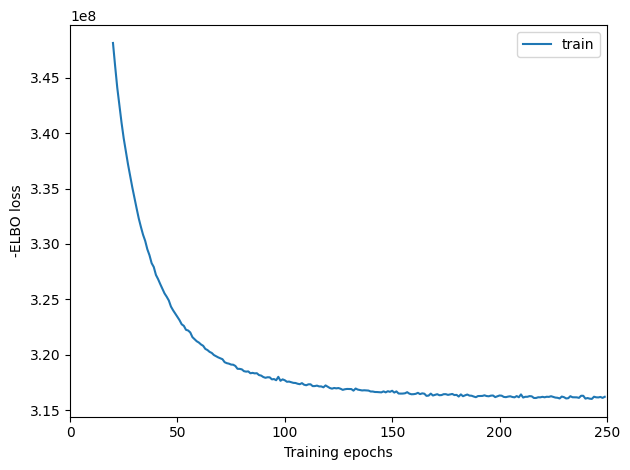

In [9]:
mod.plot_history(20)


In [10]:

results_folder = './neoadjuvant_ffpe_visium/c2l_dir'

# create paths and names to results folders for reference regression and cell2location models
ref_run_name = f'{results_folder}/reference_signatures'
run_name = f'{results_folder}/cell2location_map'


# In this section, we export the estimated cell abundance (summary of the posterior distribution).
sc_reference_data = mod.export_posterior(
    sc_reference_data, sample_kwargs={'num_samples': 1000, 'batch_size': 2500}
)

# Save model
mod.save(f"{ref_run_name}", overwrite=True)

# Save anndata object with results
adata_file = f"{ref_run_name}/sc.h5ad"
sc_reference_data.write(adata_file)

/home/ak431480/.local/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /tcsc/software/easybuild/software/jupyter-server/2.1 ...


Sampling local variables, batch:   0%|          | 0/47 [00:00<?, ?it/s]

Sampling global variables, sample:   0%|          | 0/999 [00:00<?, ?it/s]

In [11]:
#sc_reference_data = sc.read_h5ad('./c2l_dir/reference_signatures/sc.h5ad')
sc_reference_data = mod.export_posterior(
    sc_reference_data, use_quantiles=True,
    # choose quantiles
    add_to_varm=["q05","q50", "q95", "q0001"],
    sample_kwargs={'batch_size': 2500}
)

/home/ak431480/.local/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /tcsc/software/easybuild/software/jupyter-server/2.1 ...


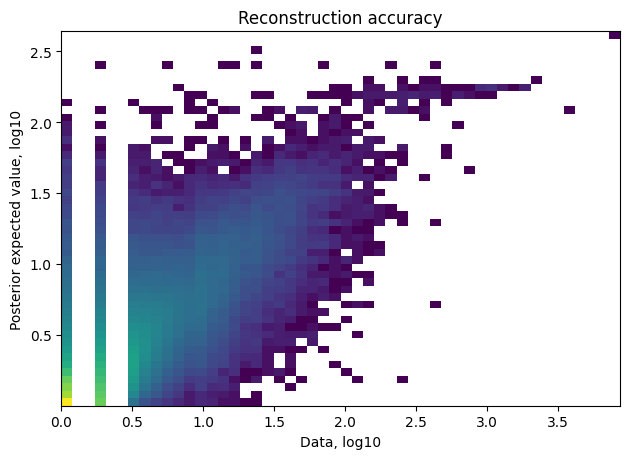

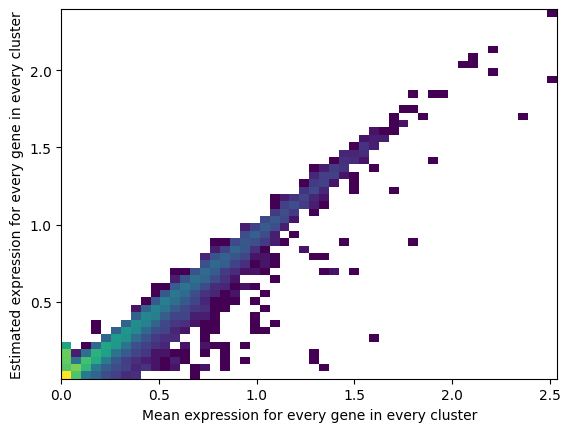

In [12]:
mod.plot_QC(summary_name="q50")

## Map the inferred single cell gene expression averages

In [6]:
sc_reference_data = sc.read_h5ad(f'{base_dir}/neoadjuvant_ffpe_visium/c2l_dir/reference_signatures/sc.h5ad')
# export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in sc_reference_data.varm.keys():
    inf_aver = sc_reference_data.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}'
                                    for i in sc_reference_data.uns['mod']['factor_names']]].copy()
else:
    inf_aver = sc_reference_data.var[[f'means_per_cluster_mu_fg_{i}'
                                    for i in sc_reference_data.uns['mod']['factor_names']]].copy()
inf_aver.columns = sc_reference_data.uns['mod']['factor_names']

inf_aver.iloc[0:5, 0:5]



,B cell_0,B cell_1,B cell_3,B cell_4,B cell_5
A2M,0.004017,0.008657,0.003880,0.012177,0.011909
A4GALT,0.002630,0.005675,0.004867,0.003426,0.008369
AAAS,0.042927,0.024208,0.006537,0.021573,0.038959
AACS,0.011350,0.004530,0.007665,0.003189,0.011447
AADAC,0.001544,0.002705,0.003580,0.003521,0.004297


In [7]:
# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(spatial_data.var_names, inf_aver.index)
spatial_data = spatial_data[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()

# prepare anndata for cell2location model
#cell2location.models.Cell2location.setup_anndata(adata=spatial_data, batch_key="sample_id",layer='counts')
#cell2location.models.Cell2location.setup_anndata(adata=spatial_data, batch_key="sample_id",categorical_covariate_keys=['location'])
cell2location.models.Cell2location.setup_anndata(adata=spatial_data, batch_key="sample_id") # X data layer contains unnormalized counts


## Create model and map

In [15]:
# create and train the model
mod = cell2location.models.Cell2location(
    spatial_data, cell_state_df=inf_aver,
    # the expected average cell abundance: tissue-dependent
    # hyper-prior which can be estimated from paired histology:
    N_cells_per_location=15,
    # hyperparameter controlling normalisation of
    # within-experiment variation in RNA detection:
    detection_alpha=20
)
mod.view_anndata_setup()

Anndata setup with scvi-tools version 1.4.0.

Setup via `Cell2location.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'sample_id',
│   'labels_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │  22   │
│         n_cells          │ 54771 │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│          n_vars          │ 15751 │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                          batch State Registry                          
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location     ┃      Categories       ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sample_id'] │   S10_D1-06-3093_P    │          0          │
│                        │   S11_A1-06-7221_P    │          1          │
│                        │  S12_D1-05-35592_I_B  │          2          │
│                        │   S13_A1-06-16086_P   │          3          │
│                        │ S14_D1-06-01637_II_B  │          4          │
│                        │   S15_A1-05-25866_P   │          5          │
│                        │  S16_D1-05-3149_I_B   │          6          │
│                        │  S17_A1-05-27153_I_P  │          7          │
│                        │ S18_D1-05-17668_II_P  │          8          │
│                        │   S19_A1-05-08617_P   │          9          │
│                        │  S1_A1-05-15590_9_P   │         10          │
│                        │ S20_D1-04-33992_II_B  │         11          │
│                        │  S21_A1-05-10603_I_B  │         12          │
│                        │   S22_D1-05-24402_P   │         13          │
│                        │  S2_D1-05-01441_II_B  │         14          │
│                        │  S3_A1-05-16905_II_P  │         15          │
│                        │  S4_D1-04-37131_I_B   │         16          │
│                        │  S5_A1-05-17318_II_B  │         17          │
│                        │ S6_D1-05-29927_III7_P │         18          │
│                        │    S7_A1-06-2116_P    │         19          │
│                        │  S8_D1-05-30372_II_B  │         20          │
│                        │  S9_A1-05-32045_I_B   │         21          │
└────────────────────────┴───────────────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

In [16]:

results_folder = './neoadjuvant_ffpe_visium/c2l_dir'
run_name = f'{results_folder}/cell2location_map'


mod.train(max_epochs=15000,
          # train using full data (batch_size=None)
          #batch_size=None,
          #batch_size=26594, # Two batches
          batch_size=17729, # Three batches
          # use all data points in training because
          # we need to estimate cell abundance at all locations
          train_size=1,
          #use_gpu=True,
         )

# Save model
mod.save(f"{run_name}", overwrite=True)

# plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history(1000)
plt.legend(labels=['full data training'])


/home/ak431480/.local/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /tcsc/software/easybuild/software/jupyter-server/2.1 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ak431480/.local/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /tcsc/software/easybuild/software/jupyter-server/2.1 ...
/home/ak431480/.local/lib/python3.11/site-packages/lightning/pytorch/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
LOCAL_RANK: 0 -

Training:   0%|          | 0/15000 [00:00<?, ?it/s]

## Cell2location model export

In [8]:
#import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

results_folder = './neoadjuvant_ffpe_visium/c2l_dir'
run_name = f'{results_folder}/cell2location_map'

mod = cell2location.models.Cell2location.load(f"{run_name}", spatial_data)

INFO     File ./neoadjuvant_ffpe_visium/c2l_dir/cell2location_map/model.pt already downloaded                      


/home/ak431480/.local/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /tcsc/software/easybuild/software/jupyter-server/2.1 ...
/home/ak431480/.local/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /tcsc/software/easybuild/software/jupyter-server/2.1 ...
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ak431480/.local/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning 

Training:   0%|          | 0/30000 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1` reached.


In [9]:

# In this section, we export the estimated cell abundance (summary of the posterior distribution).
spatial_data = mod.export_posterior(
    spatial_data, sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs} # 1000 samples is default
)

# mod = cell2location.models.Cell2location.load(f"{run_name}", spatial_data)

# Save anndata object with results
adata_file = f"{run_name}/sp.h5ad"
spatial_data.write(adata_file)
adata_file

/home/ak431480/.local/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /tcsc/software/easybuild/software/jupyter-server/2.1 ...


Sampling local variables, batch:   0%|          | 0/1 [00:00<?, ?it/s]

Sampling global variables, sample:   0%|          | 0/999 [00:00<?, ?it/s]

'./neoadjuvant_ffpe_visium/c2l_dir/cell2location_map/sp.h5ad'